In [1]:
import os
import json
import copy
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from pycalphad import calculate, equilibrium, Database, variables as v
from pycalphad.core.utils import filter_phases
from pycalphad.plot.utils import phase_legend
from scheil import simulate_scheil_solidification, simulate_equilibrium_solidification, SolidificationResult
from scheil.utils import order_disorder_dict, order_disorder_eq_phases
# local helpers.py file
# monkey patches pycalphad variables with weights, should be imported *after* pycalphad
from helpers import sample_phase_points, W_to_X, comp_interp 

Load the database file for this system

In [2]:
dbf = Database('Fe-Ni-Ti_DeKeyzer_modified.tdb')
comps = ['FE', 'NI', 'TI', 'VA']
phases = list(dbf.phases.keys())

In [3]:
# Compute a map from ordered to disorderd phases, to determine equilibrium solidification phase amounts.
ord_disord_map = order_disorder_dict(dbf, comps, phases)

## Add points near the convex hull manually

In this system, the phases are modeled with many sublattices. Sampling over the single phase energy surfaces to find and sample phase constitutions around equilibrium composition sets can greatly increase the speed and accuracy of the solver during the solidification simulations.

Here, several temperatures are sampled.

In [4]:
TEMPERATURES = [1400, 1660]
pts_dict = {}
active_phases = ['A3', 'BCC2', 'FCC4', 'NI3TI', 'NITI2', 'LIQUID', 'C14']
for phase_name in filter_phases(dbf, list(map(v.Species, comps)), phases):
    print(phase_name, end=': T= ')
    phase_pts = []
    for T in TEMPERATURES:
        print(T, end=' ')
        phase_pts.append(sample_phase_points(dbf, comps, phase_name, {v.T: T, v.P: 101325, v.N: 1, v.X('FE'): (0, 1.01, 0.1), v.X('NI'): (0, 1.01, 0.1)}, 500, 100))
    pts_dict[phase_name] = np.concatenate(phase_pts)
    print(f'- {pts_dict[phase_name].shape[0]} points')

A3: T= 1400 

/Users/brandon/Projects/pycalphad/pycalphad/core/lower_convex_hull.py:136: RuntimeWarning: invalid value encountered in double_scalars
  result_array_GM_values[it.multi_index] = new_energy / molesum


1660 - 17930 points
BCC2: T= 1400 1660 - 126277 points
C14: T= 1400 1660 - 372806 points
FCC4: T= 1400 1660 - 3261286 points
LIQUID: T= 1400 1660 - 17932 points
NI3TI: T= 1400 1660 - 52942 points
NITI2: T= 1400 1660 - 56376 points


# Individual layers

Note that in all simulations, the point dictionary will be copied. This means that each simulation will not be affected by others regardless of the number of times/order of the simulations. At the same time, the added points won't be able to accumulate through the simulations. They will be reproducible.

Common parameters for all simulations.

In [127]:
RESULTS_DIR = os.path.join('results')
if not os.path.exists(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)
LAYERS_DIR = os.path.join(RESULTS_DIR, 'layers')
if not os.path.exists(LAYERS_DIR):
    os.mkdir(LAYERS_DIR)

In [6]:
step_temperature = 10.0
verbose = True

## CP Ti

### Layer 24

In [7]:
composition = {v.W('NI'): 0.060, v.W('TI'): 0.834}
composition = W_to_X(composition, dbf, comps)
start_temperature = 1620
res = simulate_scheil_solidification(dbf, comps, phases, composition, start_temperature=start_temperature, step_temperature=step_temperature, verbose=verbose, eq_kwargs={'calc_opts': {'points': copy.deepcopy(pts_dict)}})
print(res)
with open(os.path.join(LAYERS_DIR, 'CPTi-L24.json'), 'w') as fp:
    json.dump(res.to_dict(), fp)
print(", ".join([f"({ph}: {vals[-1]:0.3f})" for ph, vals in res.cum_phase_amounts.items() if not np.isclose(vals[-1], 0)]))

building callables... done
Adding points to LIQUID. T=1620.000, X_NI=0.05, X_TI=0.86, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. T=1610.000, X_NI=0.05, X_TI=0.86, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. T=1600.000, X_NI=0.05, X_TI=0.86, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. Adding points to BCC2. New phases seen: {'A2'}. T=1590.000, X_NI=0.05, X_TI=0.86, ΔT=10.000, NL: 0.852, NP(LIQUID)=0.852 NP(A2)=0.148 
Adding points to LIQUID. Adding points to BCC2. T=1580.000, X_NI=0.06, X_TI=0.84, ΔT=10.000, NL: 0.814, NP(LIQUID)=0.955 NP(A2)=0.045 
Adding points to LIQUID. Adding points to BCC2. T=1570.000, X_NI=0.06, X_TI=0.84, ΔT=10.000, NL: 0.778, NP(LIQUID)=0.956 NP(A2)=0.044 
Adding points to LIQUID. Adding points to BCC2. T=1560.000, X_NI=0.06, X_TI=0.84, ΔT=10.000, NL: 0.744, NP(LIQUID)=0.956 NP(A2)=0.044 
Adding points to LIQUID. Adding points to BCC2. T=1550.000, X_NI=0.06, X_TI=0.83, ΔT=10.000, NL: 0.712, NP(LIQU

In [8]:
eq_sol = simulate_equilibrium_solidification(dbf, comps, phases, composition, start_temperature=start_temperature, step_temperature=step_temperature, verbose=verbose, eq_kwargs={'calc_opts': {'points': copy.deepcopy(pts_dict)}})
eq_res = equilibrium(dbf, comps, phases, {v.P: 101325, v.N: 1.0, v.T: eq_sol.temperatures[-1], **composition})
print(", ".join([f"({ph}: {val:0.3f})" for ph, val in zip(order_disorder_eq_phases(eq_res, ord_disord_map), eq_res.NP.values.squeeze()) if ph != '']))

building callables... done
(A2: 1.000)


### Layer 32

In [9]:
composition = {v.W('NI'): 0.165, v.W('TI'): 0.533}
composition = W_to_X(composition, dbf, comps)
start_temperature = 1600
res = simulate_scheil_solidification(dbf, comps, phases, composition, start_temperature=start_temperature, step_temperature=step_temperature, verbose=verbose, eq_kwargs={'calc_opts': {'points': copy.deepcopy(pts_dict)}})
print(res)
with open(os.path.join(LAYERS_DIR, 'CPTi-L32.json'), 'w') as fp:
    json.dump(res.to_dict(), fp)
print([(ph, vals[-1]) for ph, vals in res.cum_phase_amounts.items() if not np.isclose(vals[-1], 0)])

building callables... done
Adding points to LIQUID. T=1600.000, X_NI=0.15, X_TI=0.58, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. T=1590.000, X_NI=0.15, X_TI=0.58, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. T=1580.000, X_NI=0.15, X_TI=0.58, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. T=1570.000, X_NI=0.15, X_TI=0.58, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. T=1560.000, X_NI=0.15, X_TI=0.58, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. T=1550.000, X_NI=0.15, X_TI=0.58, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. T=1540.000, X_NI=0.15, X_TI=0.58, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. T=1530.000, X_NI=0.15, X_TI=0.58, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. Adding points to BCC2. New phases seen: {'BCC2'}. T=1520.000, X_NI=0.15, X_TI=0.58, ΔT=10.000, NL: 0.827, NP(LIQUID)=0.827 NP(BCC2)=0.173 
Adding points to 

In [10]:
eq_sol = simulate_equilibrium_solidification(dbf, comps, phases, composition, start_temperature=start_temperature, step_temperature=step_temperature, verbose=verbose, eq_kwargs={'calc_opts': {'points': copy.deepcopy(pts_dict)}})
eq_res = equilibrium(dbf, comps, phases, {v.P: 101325, v.N: 1.0, v.T: eq_sol.temperatures[-1], **composition})
print(", ".join([f"({ph}: {val:0.3f})" for ph, val in zip(order_disorder_eq_phases(eq_res, ord_disord_map), eq_res.NP.values.squeeze()) if ph != '']))

building callables... done
(NITI2: 0.291), (BCC2: 0.709)


## Ti-6Al-4V

### Layer 26

In [11]:
composition = {v.W('NI'): 0.127, v.W('TI'): 0.647}
composition = W_to_X(composition, dbf, comps)
start_temperature = 1400
res = simulate_scheil_solidification(dbf, comps, phases, composition, start_temperature=start_temperature, step_temperature=step_temperature, verbose=verbose, eq_kwargs={'calc_opts': {'points': copy.deepcopy(pts_dict)}})
print(res)
with open(os.path.join(LAYERS_DIR, 'Ti64-L26.json'), 'w') as fp:
    json.dump(res.to_dict(), fp)
print([(ph, vals[-1]) for ph, vals in res.cum_phase_amounts.items() if not np.isclose(vals[-1], 0)])

building callables... done
Adding points to LIQUID. T=1400.000, X_NI=0.11, X_TI=0.69, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. T=1390.000, X_NI=0.11, X_TI=0.69, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. T=1380.000, X_NI=0.11, X_TI=0.69, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to BCC2. Adding points to LIQUID. New phases seen: {'BCC2'}. T=1370.000, X_NI=0.11, X_TI=0.69, ΔT=10.000, NL: 0.944, NP(LIQUID)=0.944 NP(BCC2)=0.056 
Adding points to BCC2. Adding points to LIQUID. T=1360.000, X_NI=0.11, X_TI=0.69, ΔT=10.000, NL: 0.918, NP(LIQUID)=0.973 NP(BCC2)=0.027 
Adding points to BCC2. Adding points to LIQUID. T=1350.000, X_NI=0.11, X_TI=0.70, ΔT=10.000, NL: 0.894, NP(LIQUID)=0.974 NP(BCC2)=0.026 
Adding points to BCC2. Adding points to LIQUID. T=1340.000, X_NI=0.11, X_TI=0.70, ΔT=10.000, NL: 0.871, NP(LIQUID)=0.975 NP(BCC2)=0.025 
Adding points to BCC2. Adding points to LIQUID. T=1330.000, X_NI=0.11, X_TI=0.71, ΔT=10.000, NL: 0.85

In [12]:
eq_sol = simulate_equilibrium_solidification(dbf, comps, phases, composition, start_temperature=start_temperature, step_temperature=step_temperature, verbose=verbose, eq_kwargs={'calc_opts': {'points': copy.deepcopy(pts_dict)}})
eq_res = equilibrium(dbf, comps, phases, {v.P: 101325, v.N: 1.0, v.T: eq_sol.temperatures[-1], **composition})
print(", ".join([f"({ph}: {val:0.3f})" for ph, val in zip(order_disorder_eq_phases(eq_res, ord_disord_map), eq_res.NP.values.squeeze()) if ph != '']))

building callables... done
(A2: 0.128), (NITI2: 0.872)


### Layer 33

In [13]:
composition = {v.W('NI'): 0.249, v.W('TI'): 0.328}
composition = W_to_X(composition, dbf, comps)
start_temperature = 1700
res = simulate_scheil_solidification(dbf, comps, phases, composition, start_temperature=start_temperature, step_temperature=step_temperature, verbose=verbose, eq_kwargs={'calc_opts': {'points': copy.deepcopy(pts_dict)}})
print(res)
with open(os.path.join(LAYERS_DIR, 'Ti64-L33.json'), 'w') as fp:
    json.dump(res.to_dict(), fp)
print([(ph, vals[-1]) for ph, vals in res.cum_phase_amounts.items() if not np.isclose(vals[-1], 0)])

building callables... done
Adding points to LIQUID. T=1700.000, X_NI=0.23, X_TI=0.37, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. T=1690.000, X_NI=0.23, X_TI=0.37, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to C14. Adding points to LIQUID. New phases seen: {'C14'}. T=1680.000, X_NI=0.23, X_TI=0.37, ΔT=10.000, NL: 0.564, NP(LIQUID)=0.564 NP(C14)=0.436 
Adding points to C14. Adding points to LIQUID. T=1670.000, X_NI=0.26, X_TI=0.39, ΔT=10.000, NL: 0.505, NP(LIQUID)=0.895 NP(C14)=0.105 
Adding points to C14. Adding points to LIQUID. T=1660.000, X_NI=0.26, X_TI=0.40, ΔT=10.000, NL: 0.460, NP(LIQUID)=0.912 NP(C14)=0.088 
Adding points to C14. Adding points to LIQUID. T=1650.000, X_NI=0.27, X_TI=0.40, ΔT=10.000, NL: 0.426, NP(LIQUID)=0.925 NP(C14)=0.075 
Adding points to C14. Adding points to LIQUID. T=1640.000, X_NI=0.27, X_TI=0.41, ΔT=10.000, NL: 0.398, NP(LIQUID)=0.935 NP(C14)=0.065 
Adding points to C14. Adding points to LIQUID. T=1630.000, X_NI=0.28, X_TI

In [14]:
eq_sol = simulate_equilibrium_solidification(dbf, comps, phases, composition, start_temperature=start_temperature, step_temperature=step_temperature, verbose=verbose, eq_kwargs={'calc_opts': {'points': copy.deepcopy(pts_dict)}})
eq_res = equilibrium(dbf, comps, phases, {v.P: 101325, v.N: 1.0, v.T: eq_sol.temperatures[-1], **composition})
print(", ".join([f"({ph}: {val:0.3f})" for ph, val in zip(order_disorder_eq_phases(eq_res, ord_disord_map), eq_res.NP.values.squeeze()) if ph != '']))

building callables... done
(C14: 0.783), (BCC2: 0.217)


### Layer 35

In [15]:
composition = {v.W('NI'): 0.285, v.W('TI'): 0.235}
composition = W_to_X(composition, dbf, comps)
start_temperature = 1700
res = simulate_scheil_solidification(dbf, comps, phases, composition, start_temperature=start_temperature, step_temperature=step_temperature, verbose=verbose, eq_kwargs={'calc_opts': {'points': copy.deepcopy(pts_dict)}})
print(res)
with open(os.path.join(LAYERS_DIR, 'Ti64-L35.json'), 'w') as fp:
    json.dump(res.to_dict(), fp)
print([(ph, vals[-1]) for ph, vals in res.cum_phase_amounts.items() if not np.isclose(vals[-1], 0)])

building callables... done
Adding points to LIQUID. T=1700.000, X_NI=0.26, X_TI=0.27, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. T=1690.000, X_NI=0.26, X_TI=0.27, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. T=1680.000, X_NI=0.26, X_TI=0.27, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. T=1670.000, X_NI=0.26, X_TI=0.27, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. Adding points to C14. New phases seen: {'C14'}. T=1660.000, X_NI=0.26, X_TI=0.27, ΔT=10.000, NL: 0.801, NP(LIQUID)=0.801 NP(C14)=0.199 
Adding points to LIQUID. Adding points to C14. T=1650.000, X_NI=0.28, X_TI=0.26, ΔT=10.000, NL: 0.735, NP(LIQUID)=0.918 NP(C14)=0.082 
Adding points to LIQUID. Adding points to C14. T=1640.000, X_NI=0.29, X_TI=0.25, ΔT=10.000, NL: 0.683, NP(LIQUID)=0.928 NP(C14)=0.072 
Adding points to LIQUID. Adding points to C14. T=1630.000, X_NI=0.29, X_TI=0.24, ΔT=10.000, NL: 0.639, NP(LIQUID)=0.936 NP(C14)=0.064 
Adding poin

In [16]:
eq_sol = simulate_equilibrium_solidification(dbf, comps, phases, composition, start_temperature=start_temperature, step_temperature=step_temperature, verbose=verbose, eq_kwargs={'calc_opts': {'points': copy.deepcopy(pts_dict)}})
eq_res = equilibrium(dbf, comps, phases, {v.P: 101325, v.N: 1.0, v.T: eq_sol.temperatures[-1], **composition})
print(", ".join([f"({ph}: {val:0.3f})" for ph, val in zip(order_disorder_eq_phases(eq_res, ord_disord_map), eq_res.NP.values.squeeze()) if ph != '']))

building callables... done
(NI3TI: 0.034), (C14: 0.835), (A1: 0.131)


#### Visualizations

##### Phase fractions through solidification

Text(0, 0.5, 'Phase Fraction')

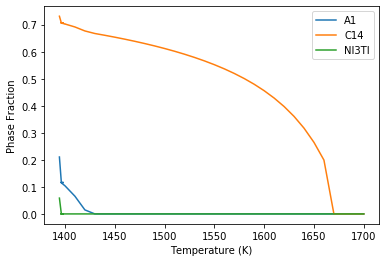

In [17]:
for phase_name, amounts in res.cum_phase_amounts.items():
    if amounts[-1] > 0:  # If the total phase fraction is non-zero
        plt.plot(res.temperatures, amounts, label=phase_name)
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Phase Fraction')

##### Solidification path

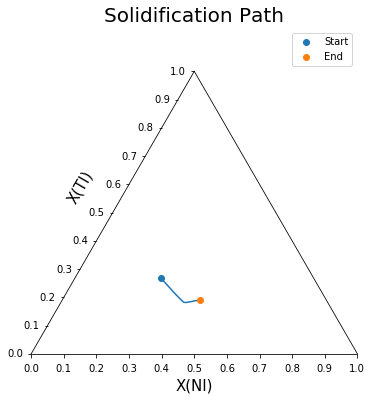

In [57]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='triangular')
ax.plot(res.x_liquid['NI'], res.x_liquid['TI'])
ax.scatter([res.x_liquid['NI'][0]], [res.x_liquid['TI'][0]], label='Start', zorder=10)
ax.scatter([res.x_liquid['NI'][-2]], [res.x_liquid['TI'][-2]], label='End', zorder=10)
ax.set_xlabel('X(NI)', size=15)
ax.set_ylabel('X(TI)', rotation=60, labelpad=-80, size=15)
ax.set_title('Solidification Path', size=20)
ax.legend()

### Layer 45

In [58]:
composition = {v.W('NI'): 0.332, v.W('TI'): 0.120}
composition = W_to_X(composition, dbf, comps)
start_temperature = 1540
res = simulate_scheil_solidification(dbf, comps, phases, composition, start_temperature=start_temperature, step_temperature=step_temperature, verbose=verbose, eq_kwargs={'calc_opts': {'points': copy.deepcopy(pts_dict)}})
print(res)
with open(os.path.join(LAYERS_DIR, 'Ti64-L45.json'), 'w') as fp:
    json.dump(res.to_dict(), fp)
print([(ph, vals[-1]) for ph, vals in res.cum_phase_amounts.items() if not np.isclose(vals[-1], 0)])

building callables... done
Adding points to LIQUID. T=1540.000, X_NI=0.31, X_TI=0.14, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. T=1530.000, X_NI=0.31, X_TI=0.14, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. T=1520.000, X_NI=0.31, X_TI=0.14, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. T=1510.000, X_NI=0.31, X_TI=0.14, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. Adding points to FCC4. New phases seen: {'A1'}. T=1500.000, X_NI=0.31, X_TI=0.14, ΔT=10.000, NL: 0.924, NP(LIQUID)=0.924 NP(A1)=0.076 
Adding points to LIQUID. Adding points to FCC4. T=1490.000, X_NI=0.32, X_TI=0.14, ΔT=10.000, NL: 0.839, NP(LIQUID)=0.907 NP(A1)=0.093 
Adding points to LIQUID. Adding points to FCC4. T=1480.000, X_NI=0.32, X_TI=0.15, ΔT=10.000, NL: 0.763, NP(LIQUID)=0.910 NP(A1)=0.090 
Adding points to FCC4. Adding points to LIQUID. T=1470.000, X_NI=0.33, X_TI=0.15, ΔT=10.000, NL: 0.696, NP(LIQUID)=0.912 NP(A1)=0.088 
Adding point

In [59]:
eq_sol = simulate_equilibrium_solidification(dbf, comps, phases, composition, start_temperature=start_temperature, step_temperature=step_temperature, verbose=verbose, eq_kwargs={'calc_opts': {'points': copy.deepcopy(pts_dict)}})
eq_res = equilibrium(dbf, comps, phases, {v.P: 101325, v.N: 1.0, v.T: eq_sol.temperatures[-1], **composition})
print(", ".join([f"({ph}: {val:0.3f})" for ph, val in zip(order_disorder_eq_phases(eq_res, ord_disord_map), eq_res.NP.values.squeeze()) if ph != '']))

building callables... done
(A1: 0.862), (C14: 0.138)


# Gradient Path Solidification
## Path construction

Build a composition path from pure Ti to Invar-36 (Fe-36 wt% Ni). Weight fractions are converted to mole fractions (as used by pycalphad).

Scheil-Gulliver and equilibrium solidification simulations will loop over this linear path.

In [38]:
start = {v.W('NI'): 0.0, v.W('TI'): 1.0} # pure Ti
end = {v.W('NI'): 0.36, v.W('TI'): 0.0}  # Invar-36
def fmt_comps(comp_conds):
    return '-'.join([f'{c}={val:0.3f}' for c, val in comp_conds.items()])

all_comps = []  # mole fraction
for mix in np.linspace(1e-3, 1, 50):
    all_comps.append(W_to_X(comp_interp(start, end, mix), dbf, comps))

# Note, compositions here are in mole fraction, but input were mass fraction.
print(f"Start: {fmt_comps(all_comps[0])}")
print(f"End  : {fmt_comps(all_comps[-1])}")

Start: X_NI=0.000-X_TI=0.999
End  : X_NI=0.349-X_TI=0.000


## Scheil-Gulliver
### Settings

Save the results in a local results directory and set the main controlling.

The start temperature should be the highest temperature that is pure liquid along the whole path. Titanium has a melting point of about 1940 K, so 2000 K is chosen.

In [128]:
RESULTS_DIR = os.path.join('results')
if not os.path.exists(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)
PATH_DIR = os.path.join(RESULTS_DIR, 'scheil-path')
if not os.path.exists(PATH_DIR):
    os.mkdir(PATH_DIR)
START_TEMPERATURE = 2000.0  # global start temperature
STEP_TEMPERATURE = 10.0  # temperature step size
VERBOSE = False

### Simulations

Typically each simulation on the path finishes in ~7 minutes on average for a 2015 MacBook Pro with an Intel i7 processor.
50 compositions gives a total time of about 6 hours.

In [ ]:
prefix = 'Fe-Ni-Ti_path'  # file name prefix
# copy points at first for reproducibilty, but use along the whole path for speed and accuracy
path_pts = copy.deepcopy(pts_dict)
for i, composition in enumerate(all_comps):
    formatted_name = fmt_comps(composition)
    print(formatted_name, end='  ==  ')
    res = simulate_scheil_solidification(dbf, comps, phases, composition, start_temperature=START_TEMPERATURE, adaptive=True, step_temperature=STEP_TEMPERATURE, verbose=VERBOSE, eq_kwargs={'calc_opts': {'points': path_pts}})
    for ph, amnts in res.cum_phase_amounts.items():
        print(f'{ph}: {amnts[-1]:0.4f}', end=', ')
    print()
    with open(os.path.join(PATH_DIR, f'{prefix}_i={i:03d}_{formatted_name}.json'), 'w') as fp:
        json.dump(res.to_dict(), fp)

### Plotting
Load the data for the path from the results directory and create a dictionary mapping a phase to the fractions along the path.

In [124]:
MIN_PHASE_FRACTION = 1e-6
solid_phases = [ph for ph in phases if ph != 'LIQUID']
phase_fractions = {ph: [] for ph in solid_phases if ph != solid_phases}
for filename in sorted(glob(os.path.join(f'{PATH_DIR}', '*'))):
    with open(filename) as fp:
        data = json.load(fp)
    sol_res = SolidificationResult.from_dict(data)
    for ph in solid_phases:
        phase_fractions[ph].append(sol_res.cum_phase_amounts[ph][-1])
# Only include phases that have *some* amount greater than MIN_PHASE_FRACTION
phase_fractions = {ph: np.array(fracs) for ph, fracs in phase_fractions.items() if np.max(fracs) > MIN_PHASE_FRACTION}

Manually set the line styles and coloring.

In [125]:
LINE_STYLES = {
    'A1': 'dotted',
    'A2': (0, (3, 5, 1, 5)),
    'A3': (0, (3, 10, 1, 10)),
    'BCC2': (0, (5, 5)),
    'C14': 'dashed',
    'FCC4': (0, (5, 10)),
    'NI3TI': 'solid',
    'NITI2': 'dashdot'
}
COLORS = {
    'A1': '#000000',
    'A2': '#000075',
    'A3': '#808000',
    'BCC2': '#911eb4',
    'C14': '#f58231',
    'FCC4': '#800000',
    'NI3TI': '#3cb44b',
    'NITI2': '#9A6324'
}

Plot the phase fractions.

(-0.01, 1.01)

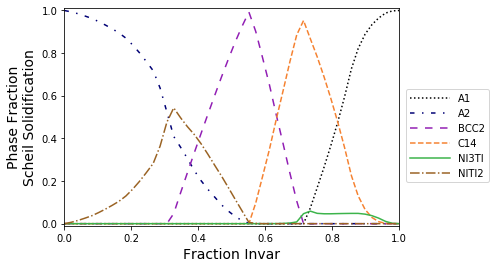

In [126]:
path_xs = np.linspace(0, 1, list(phase_fractions.values())[0].size) # plotting along the fraction of Invar
fig = plt.figure()
ax = fig.gca()
for ph, fracs in phase_fractions.items():
    ax.plot(path_xs, fracs, color=COLORS[ph], ls=LINE_STYLES[ph], label=ph)


ax.set_xlabel('Fraction Invar', fontsize=14)
ax.set_ylabel('Phase Fraction\nScheil Solidification', fontsize=14)
#ax.legend(legend_handles, {ph: COLORS[ph] for ph in sorted(phase_fractions.keys())}, loc=(1.02,0.2))
ax.legend(loc=(1.02,0.2), handlelength=4)
ax.set_xlim(0, 1)
ax.set_ylim(-0.01, 1.01)
# fig.savefig('NP-solidification.svg')

## Calculating equilibrium solidification phase fraction 

### Settings

Since the phase fractions we are interested in plotting are at the end of the simulations and the equilibrium solidification simulations do a binary search at the end, we don't need as fine of a step size.

In [129]:
RESULTS_DIR = os.path.join('results')
if not os.path.exists(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)
PATH_DIR = os.path.join(RESULTS_DIR, 'eq-path')
if not os.path.exists(PATH_DIR):
    os.mkdir(PATH_DIR)
START_TEMPERATURE = 2000.0  # global start temperature
STEP_TEMPERATURE = 10.0  # temperature step size
VERBOSE = False

### Simulations

Typically each simulation on the path finishes in ~4 minutes on average for a 2015 MacBook Pro with an Intel i7 processor.

In [ ]:
prefix = 'Fe-Ni-Ti_path'
# copy points at first for reproducibilty, but use along the whole path for speed
path_pts = copy.deepcopy(pts_dict)
for i, composition in enumerate(all_comps):
    formatted_name = fmt_comps(composition)
    print(formatted_name, end='  ==  ')
    res = simulate_equilibrium_solidification(dbf, comps, phases, composition, start_temperature=START_TEMPERATURE, adaptive=True, step_temperature=STEP_TEMPERATURE, verbose=VERBOSE, eq_kwargs={'calc_opts': {'points': path_pts}})
    for ph, amnts in res.cum_phase_amounts.items():
        print(f'{ph}: {amnts[-1]:0.4f}', end=', ')
    print()
    with open(os.path.join(PATH_DIR, f'{prefix}_i={i:03d}_{formatted_name}.json'), 'w') as fp:
        json.dump(res.to_dict(), fp)

In [117]:
MIN_PHASE_FRACTION = 1e-6
solid_phases = [ph for ph in phases if ph != 'LIQUID']
phase_fractions = {ph: [] for ph in solid_phases if ph != solid_phases}
for filename in sorted(glob(os.path.join(f'{PATH_DIR}', '*'))):
    with open(filename) as fp:
        data = json.load(fp)
    sol_res = SolidificationResult.from_dict(data)
    for ph in solid_phases:
        phase_fractions[ph].append(sol_res.cum_phase_amounts[ph][-1])
# Only include phases that have *some* amount greater than MIN_PHASE_FRACTION
phase_fractions = {ph: np.array(fracs) for ph, fracs in phase_fractions.items() if np.max(fracs) > MIN_PHASE_FRACTION}

In [121]:
# Same styles and colors as in the Scheil-Gulliver path plot
LINE_STYLES = {
    'A1': 'dotted',
    'A2': (0, (3, 5, 1, 5)),
    'A3': (0, (3, 10, 1, 10)),
    'BCC2': (0, (5, 5)),
    'C14': 'dashed',
    'FCC4': (0, (5, 10)),
    'NI3TI': 'solid',
    'NITI2': 'dashdot'
}
COLORS = {
    'A1': '#000000',
    'A2': '#000075',
    'A3': '#808000',
    'BCC2': '#911eb4',
    'C14': '#f58231',
    'FCC4': '#800000',
    'NI3TI': '#3cb44b',
    'NITI2': '#9A6324'
}

(-0.01, 1.01)

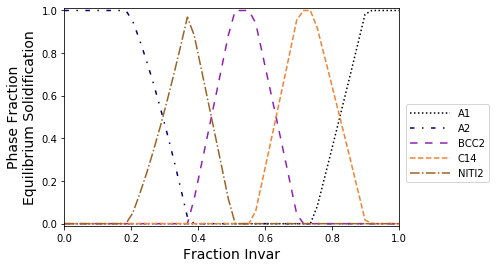

In [122]:
path_xs = np.linspace(0, 1, list(phase_fractions.values())[0].size) # plotting along the fraction of Invar
fig = plt.figure()
ax = fig.gca()
for ph, fracs in phase_fractions.items():
    ax.plot(path_xs, fracs, color=COLORS[ph], ls=LINE_STYLES[ph], label=ph)


ax.set_xlabel('Fraction Invar', fontsize=14)
ax.set_ylabel('Phase Fraction\nEquilibrium Solidification', fontsize=14)
ax.legend(loc=(1.02,0.2), handlelength=4)
ax.set_xlim(0, 1)
ax.set_ylim(-0.01, 1.01)
# fig.savefig('NP-solidification.svg')

## Run Scheil simulation in the ternary, adding the additional points
### Layer 35

In [30]:
# Layer 35
W_i = {v.W('NI'): 0.285, v.W('TI'): 0.235}

composition = W_to_X(W_i, dbf, comps)
print(composition)

{X_NI: 0.26450314059414565, X_TI: 0.2673399134199201}


In [32]:
res = simulate_scheil_solidification(dbf, comps, phases, composition, start_temperature=1700, step_temperature=10, verbose=True, eq_kwargs={'calc_opts': {'points': pts_dict}})
for ph, amnts in res.phase_amounts.items():
    print(f'{ph}: {amnts[-1]:0.4f}')

building callables... done
Adding points to LIQUID. T=1700.000, X_NI=0.26, X_TI=0.27, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. T=1690.000, X_NI=0.26, X_TI=0.27, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. T=1680.000, X_NI=0.26, X_TI=0.27, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000 
Adding points to LIQUID. Adding points to C14. New phases seen: {'C14'}. T=1670.000, X_NI=0.26, X_TI=0.27, ΔT=10.000, NL: 0.888, NP(LIQUID)=0.888 NP(C14)=0.112 
Adding points to LIQUID. Adding points to C14. T=1660.000, X_NI=0.27, X_TI=0.26, ΔT=10.000, NL: 0.804, NP(LIQUID)=0.905 NP(C14)=0.095 
Adding points to LIQUID. Adding points to C14. T=1650.000, X_NI=0.28, X_TI=0.26, ΔT=10.000, NL: 0.738, NP(LIQUID)=0.918 NP(C14)=0.082 
Adding points to LIQUID. Adding points to C14. T=1640.000, X_NI=0.29, X_TI=0.25, ΔT=10.000, NL: 0.685, NP(LIQUID)=0.928 NP(C14)=0.072 
Adding points to C14. Adding points to LIQUID. T=1630.000, X_NI=0.29, X_TI=0.25, ΔT=10.000, NL: 0.641, NP(LIQU

In [13]:
# points have been added!
for ph, pt in pts_dict.items():
    print(f'{ph}: {pt.shape[0]} points')

BCC2: 62886 points
C14: 194281 points
FCC4: 42155 points


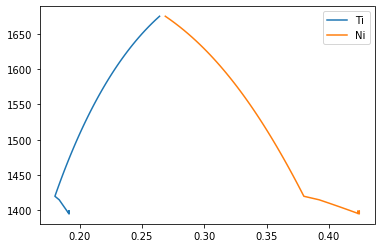

In [10]:
num_plt = np.sum(np.array(res.fraction_solid) > 0)
xTi = [z[v.X('TI')] for z in res.x_liquid][-num_plt:]
xNi = [z[v.X('NI')] for z in res.x_liquid][-num_plt:]
T = res.temperatures[-num_plt:]
plt.plot(xTi, T, label='Ti')
plt.plot(xNi, T, label='Ni')
plt.legend()

In [11]:
# save
serialize(res, 'Fe-Ni-Ti_Ti64-L35.json')

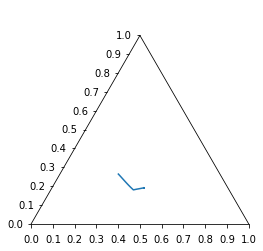

In [12]:
ax = plt.gca(projection='triangular')
ax.plot(xNi, xTi)

### CP Ti layer 24

In [14]:
W_i = {v.W('NI'): 0.060, v.W('TI'): 0.834}
composition = W_to_X(W_i, dbf, comps)
print(composition)

{X_NI: 0.05026428028320319, X_TI: 0.8564149431185173}


In [15]:
res = simulate_scheil_solidification(dbf, comps, phases, composition, start_temperature=1700, step_temperature=5, verbose=True, eq_kwargs={'calc_opts': {'points': pts_dict}})

building callables... done
T=1700.000, X_NI=0.05, X_TI=0.86, ΔT=5.000, NL: 1.000, NP(LIQUID)=1.000
T=1695.000, X_NI=0.05, X_TI=0.86, ΔT=5.000, NL: 1.000, NP(LIQUID)=1.000
T=1690.000, X_NI=0.05, X_TI=0.86, ΔT=5.000, NL: 1.000, NP(LIQUID)=1.000
T=1685.000, X_NI=0.05, X_TI=0.86, ΔT=5.000, NL: 1.000, NP(LIQUID)=1.000
T=1680.000, X_NI=0.05, X_TI=0.86, ΔT=5.000, NL: 1.000, NP(LIQUID)=1.000
T=1675.000, X_NI=0.05, X_TI=0.86, ΔT=5.000, NL: 1.000, NP(LIQUID)=1.000
T=1670.000, X_NI=0.05, X_TI=0.86, ΔT=5.000, NL: 1.000, NP(LIQUID)=1.000
T=1665.000, X_NI=0.05, X_TI=0.86, ΔT=5.000, NL: 1.000, NP(LIQUID)=1.000
T=1660.000, X_NI=0.05, X_TI=0.86, ΔT=5.000, NL: 1.000, NP(LIQUID)=1.000
T=1655.000, X_NI=0.05, X_TI=0.86, ΔT=5.000, NL: 1.000, NP(LIQUID)=1.000
T=1650.000, X_NI=0.05, X_TI=0.86, ΔT=5.000, NL: 1.000, NP(LIQUID)=1.000
T=1645.000, X_NI=0.05, X_TI=0.86, ΔT=5.000, NL: 1.000, NP(LIQUID)=1.000
T=1640.000, X_NI=0.05, X_TI=0.86, ΔT=5.000, NL: 1.000, NP(LIQUID)=1.000
T=1635.000, X_NI=0.05, X_TI=0.86, ΔT=

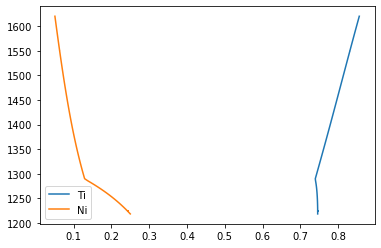

In [16]:
num_plt = np.sum(np.array(res.fraction_solid) > 0)
xTi = [z[v.X('TI')] for z in res.x_liquid][-num_plt:]
xNi = [z[v.X('NI')] for z in res.x_liquid][-num_plt:]
T = res.temperatures[-num_plt:]
plt.plot(xTi, T, label='Ti')
plt.plot(xNi, T, label='Ni')
plt.legend()

In [17]:
serialize(res, 'Fe-Ni-Ti_CPTi-L24.json')

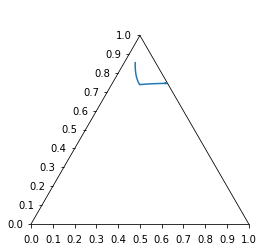

In [18]:
ax = plt.gca(projection='triangular')
ax.plot(xNi, xTi)

## Ti64 Layer 33

In [23]:
W_i = {v.W('NI'): 0.249, v.W('TI'): 0.328}
composition = W_to_X(W_i, dbf, comps)
print(composition)

{X_NI: 0.22727540256237252, X_TI: 0.36697535567956796}


In [26]:
res = simulate_scheil_solidification(dbf, comps, phases, composition, start_temperature=1720, step_temperature=5, verbose=True, eq_kwargs={'calc_opts': {'points': pts_dict}})

building callables... done
T=1720.000, X_NI=0.23, X_TI=0.37, ΔT=5.000, NL: 1.000, NP(LIQUID)=1.000
T=1715.000, X_NI=0.23, X_TI=0.37, ΔT=5.000, NL: 1.000, NP(LIQUID)=1.000
T=1710.000, X_NI=0.23, X_TI=0.37, ΔT=5.000, NL: 1.000, NP(LIQUID)=1.000
Adding points to C14. New phases seen: {'C14'}.
T=1705.000, X_NI=0.23, X_TI=0.37, ΔT=5.000, NL: 0.899, NP(LIQUID)=0.899 NP(C14)=0.101
Adding points to C14. T=1700.000, X_NI=0.23, X_TI=0.37, ΔT=5.000, NL: 0.799, NP(LIQUID)=0.889 NP(C14)=0.111
Adding points to C14. T=1695.000, X_NI=0.24, X_TI=0.38, ΔT=5.000, NL: 0.724, NP(LIQUID)=0.906 NP(C14)=0.094
Adding points to C14. T=1690.000, X_NI=0.24, X_TI=0.38, ΔT=5.000, NL: 0.665, NP(LIQUID)=0.919 NP(C14)=0.081
Adding points to C14. T=1685.000, X_NI=0.25, X_TI=0.38, ΔT=5.000, NL: 0.618, NP(LIQUID)=0.929 NP(C14)=0.071
Adding points to C14. T=1680.000, X_NI=0.25, X_TI=0.39, ΔT=5.000, NL: 0.579, NP(LIQUID)=0.937 NP(C14)=0.063
Adding points to C14. T=1675.000, X_NI=0.26, X_TI=0.39, ΔT=5.000, NL: 0.547, NP(LIQ

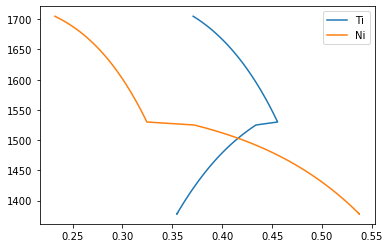

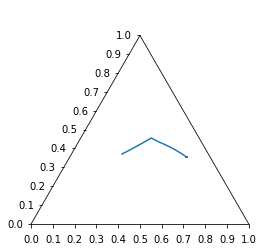

In [27]:
num_plt = np.sum(np.array(res.fraction_solid) > 0)
xTi = [z[v.X('TI')] for z in res.x_liquid][-num_plt:]
xNi = [z[v.X('NI')] for z in res.x_liquid][-num_plt:]
T = res.temperatures[-num_plt:]
plt.plot(xTi, T, label='Ti')
plt.plot(xNi, T, label='Ni')
plt.legend()
plt.show()

plt.figure()
ax = plt.gca(projection='triangular')
ax.plot(xNi, xTi)

In [28]:
serialize(res, 'Fe-Ni-Ti_Ti64-L26.json')

# Path

Scheil path between pure Ti and Invar-36

In [23]:
start = {v.W('NI'): 0.0005, v.W('TI'): 1.0-0.001} # pure Ti
end = {v.W('NI'): 0.36-0.005, v.W('TI'): 0.01}  # Invar-36

all_comps = []  # mole fraction
for mix in np.linspace(0, 1, 51):
    all_comps.append(W_to_X(comp_interp(start, end, mix), dbf, comps))

NameError: name 'comp_interp' is not defined

In [122]:
def fmt_comps(comp_conds):
    return '-'.join(['{}={:0.2f}'.format(c, val) for c, val in comp_conds.items()])

In [123]:
def fmt_comps(comp_conds):
    return '-'.join(['{}={:0.2f}'.format(c, val) for c, val in comp_conds.items()])
prefix = 'Fe-Ni-Ti_PATH_f'
dT = 5
for composition in all_comps:
    formatted_name = fmt_comps(composition)
    print(formatted_name)
    res = simulate_scheil_solidification(dbf, comps, phases, composition, start_temperature=2000, step_temperature=dT, verbose=False, eq_kwargs={'calc_opts': {'points': pts_dict}})
    print(formatted_name)
    for ph, amnts in res.phase_amounts.items():
        print(f'{ph}: {amnts[-1]:0.4f}')
#     plt.figure()
#     num_plt = np.sum(np.array(res.fraction_solid) > 0)
#     xTi = [z[v.X('TI')] for z in res.x_liquid][-num_plt:]
#     xNi = [z[v.X('NI')] for z in res.x_liquid][-num_plt:]
#     T = res.temperatures[-num_plt:]
#     plt.plot(xTi, T, label='Ti')
#     plt.plot(xNi, T, label='Ni')
#     plt.title(formatted_name)
#     plt.legend()
#     plt.show()

#     fig = plt.figure()
#     ax = fig.gca(projection='triangular')
#     ax.plot(xNi, xTi)
#     ax.set_xlabel('Ni')
#     ax.set_ylabel('Ti')
#     ax.set_title(formatted_name)
#     fig.show()

    serialize(res, f'{prefix}_dT={dT}{formatted_name}.json')

In [125]:
dT = 5
for composition in all_comps:
    formatted_name = fmt_comps(composition)
    print(formatted_name)
    res = simulate_scheil_solidification(dbf, comps, phases, composition, start_temperature=2000, step_temperature=dT, verbose=False, eq_kwargs={'calc_opts': {'points': pts_dict}})
    print(formatted_name)
    for ph, amnts in res.phase_amounts.items():
        print(f'{ph}: {amnts[-1]:0.4f}')
#     plt.figure()
#     num_plt = np.sum(np.array(res.fraction_solid) > 0)
#     xTi = [z[v.X('TI')] for z in res.x_liquid][-num_plt:]
#     xNi = [z[v.X('NI')] for z in res.x_liquid][-num_plt:]
#     T = res.temperatures[-num_plt:]
#     plt.plot(xTi, T, label='Ti')
#     plt.plot(xNi, T, label='Ni')
#     plt.title(formatted_name)
#     plt.legend()
#     plt.show()

#     fig = plt.figure()
#     ax = fig.gca(projection='triangular')
#     ax.plot(xNi, xTi)
#     ax.set_xlabel('Ni')
#     ax.set_ylabel('Ti')
#     ax.set_title(formatted_name)
#     fig.show()

    serialize(res, f'{prefix}_dT={dT}{formatted_name}.json')

X_NI=0.00-X_TI=1.00
X_NI=0.00-X_TI=1.00
A1: 0.0000
A2: 0.0000
A3: 0.0000
BCC2: 0.9999
C14: 0.0000
FCC4: 0.0000
NI3TI: 0.0000
NITI2: 0.0001
X_NI=0.01-X_TI=0.98
X_NI=0.01-X_TI=0.98
A1: 0.0000
A2: 0.0000
A3: 0.0000
BCC2: 0.9929
C14: 0.0000
FCC4: 0.0000
NI3TI: 0.0000
NITI2: 0.0071
X_NI=0.01-X_TI=0.97
X_NI=0.01-X_TI=0.97
A1: 0.0000
A2: 0.0000
A3: 0.0000
BCC2: 0.9837
C14: 0.0000
FCC4: 0.0000
NI3TI: 0.0000
NITI2: 0.0163
X_NI=0.02-X_TI=0.95
Convergence failure: T=1595 and X_NI=0.07, X_TI=0.85
Convergence failure: T=1504.5454545454554 and X_NI=0.09, X_TI=0.82
Convergence failure: T=1269.4214876033052 and X_NI=0.16, X_TI=0.74
X_NI=0.02-X_TI=0.95
A1: 0.0000
A2: 0.0000
A3: 0.0000
BCC2: 0.9724
C14: 0.0000
FCC4: 0.0000
NI3TI: 0.0000
NITI2: 0.0276
X_NI=0.02-X_TI=0.93
Convergence failure: T=1595 and X_NI=0.06, X_TI=0.85
Convergence failure: T=1500.000000000001 and X_NI=0.09, X_TI=0.82
X_NI=0.02-X_TI=0.93
A1: 0.0000
A2: 0.0000
A3: 0.0000
BCC2: 0.9597
C14: 0.0000
FCC4: 0.0000
NI3TI: 0.0000
NITI2: 0.0403

# Energy surface plotting


In [34]:
import ipyvolume as ipv
from pycalphad import calculate, Database, variables as v

In [45]:
# ipvolume helpers
from scipy.interpolate import griddata
import numpy as np
def gridit(x,y,z,lingrid):
    """
    Put linear x, y, z on a grid of lingrid (also 1d), returning X, Y, Z, each of shape (N, N) where N = lingrid.size
    """
    X, Y = np.meshgrid(lingrid, lingrid)
    Z = griddata(np.array([x,y]).T, z, (X, Y))
    return X, Y, Z

def transf(x, y):
    """Transform x and y into triangular x and y"""
    xx = x + 0.5*y
    yy = np.sqrt(3.0)/2.0*y
    return xx, yy
from matplotlib import cm
def get_cmap(cmap, Z, scale=None):
    scale = scale if scale is not None else Z
    scaled_vals = Z - np.nanmin(scale)
    scaled_vals /= scale[~np.isnan(scale)].ptp()
    try:
        colormap = getattr(cm, cmap)
    except AttributeError:
        return cmap
    return colormap(scaled_vals)


# for plotting, sample the whole surface, to prove that the local points are near the minimum
cr_c14 = calculate(dbf, comps, 'C14', T=1660, P=101325, N=1, pdens=50)
cr_c14_adapted = calculate(dbf, comps, 'C14', T=1660, P=101325, N=1, points=pts_dict)
# cr_add = calculate(dbf, comps, 'C14', T=1660, P=101325, N=1, points={'C14': loc_pts})
cr_liquid = calculate(dbf, comps, 'LIQUID', T=1660, P=101325, N=1, pdens=10000)

In [56]:
ipv.figure()


x_comp_idx = 1
y_comp_idx = 2
prop = 'GM'

# Plot C14 with pdens
cr = cr_c14

x = cr.X.isel(component=x_comp_idx).values.squeeze()
y = cr.X.isel(component=y_comp_idx).values.squeeze()
x, y =  transf(x, y)
z = cr[prop].values.squeeze()

color=get_cmap('plasma', -z)
ipv.scatter(x, y, z, color=color, size=1)

# Set plot data
ipv.xlabel(str(cr.component[x_comp_idx].values.squeeze()))
ipv.ylabel(str(cr.component[y_comp_idx].values.squeeze()))
ipv.zlabel(prop)

# # Plot C14 additonal points
cr = cr_c14_adapted
x = cr.X.isel(component=x_comp_idx).values.squeeze()
y = cr.X.isel(component=y_comp_idx).values.squeeze()
x, y =  transf(x, y)
prev_z = z
z = cr[prop].values.squeeze()
color=get_cmap('plasma', -z, -prev_z)
ipv.scatter(x, y, z, color=color, size=1)

# Plot liquid
cr = cr_liquid
x = cr.X.isel(component=x_comp_idx).values.squeeze()
y = cr.X.isel(component=y_comp_idx).values.squeeze()
x, y =  transf(x, y)
z = cr[prop].values.squeeze()
color='blue'
ipv.scatter(x, y, z, color=color, size=1)


#
ipv.save('interactive-output/all-surf.html', offline=True)

In [54]:
ipv.figure()


x_comp_idx = 1
y_comp_idx = 2
prop = 'GM'

# Plot C14 with pdens
cr = cr_c14

x = cr.X.isel(component=x_comp_idx).values.squeeze()
y = cr.X.isel(component=y_comp_idx).values.squeeze()
x, y =  transf(x, y)
z = cr[prop].values.squeeze()

color=get_cmap('plasma', -z)
ipv.scatter(x, y, z, color=color, size=1)

# Set plot data
ipv.xlabel(str(cr.component[x_comp_idx].values.squeeze()))
ipv.ylabel(str(cr.component[y_comp_idx].values.squeeze()))
ipv.zlabel(prop)

# # Plot C14 additonal points
# cr = cr_c14_adapted
# x = cr.X.isel(component=x_comp_idx).values.squeeze()
# y = cr.X.isel(component=y_comp_idx).values.squeeze()
# x, y =  transf(x, y)
# prev_z = z
# z = cr[prop].values.squeeze()
# color=get_cmap('plasma', -z, -prev_z)
# ipv.scatter(x, y, z, color=color, size=1)

# Plot liquid
cr = cr_liquid
x = cr.X.isel(component=x_comp_idx).values.squeeze()
y = cr.X.isel(component=y_comp_idx).values.squeeze()
x, y =  transf(x, y)
z = cr[prop].values.squeeze()
color='blue'
ipv.scatter(x, y, z, color=color, size=1)


#
ipv.save('interactive-output/c14-liquid-surf.html', offline=True)

# Read data and plot NP vs. X figure

In [99]:
import json
from glob import glob
solid_phases = [ph for ph in phases if ph != 'LIQUID']
phase_fractions = {ph: [] for ph in solid_phases if ph != solid_phases}
for filename in sorted(glob(f'{prefix}*')):
    with open(filename) as fp:
        data = json.load(fp)
    for ph in solid_phases:
        phase_fractions[ph].append(data['phase_amounts'][ph][-1])
phase_fractions = {ph: np.array(fracs) for ph, fracs in phase_fractions.items() if np.max(fracs) > 1e-6}


In [119]:
phase_fractions2 = {ph: [] for ph in solid_phases if ph != solid_phases}
for filename in sorted(glob(f'{prefix}*')):
    with open(filename) as fp:
        data = json.load(fp)
    for ph in solid_phases:
        phase_fractions2[ph].append(data['phase_amounts'][ph][-1])
phase_fractions2 = {ph: np.array(fracs) for ph, fracs in phase_fractions.items() if np.max(fracs) > 1e-6}



In [71]:
import matplotlib

# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"


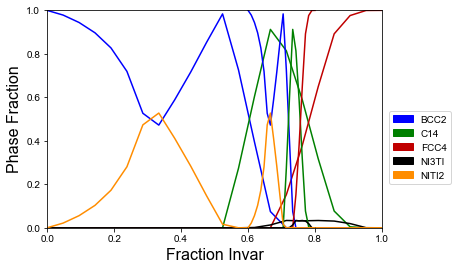

In [120]:
path_xs = np.linspace(0, 1, list(phase_fractions.values())[0].size)
from pycalphad.plot.utils import phase_legend
leg, col = phase_legend(phase_fractions.keys())


fig = plt.figure()
ax = fig.gca()
for ph, fracs in phase_fractions.items():
    ax.plot(path_xs, fracs, color=col[ph])
path_xs2 = np.linspace(0.6, 0.8, list(phase_fractions.values())[0].size)
for ph, fracs in phase_fractions2.items():
    ax.plot(path_xs2, fracs, color=col[ph])


ax.set_xlabel('Fraction Invar', fontsize=16)
ax.set_ylabel('Phase Fraction', fontsize=16)
ax.legend(leg, col, loc=(1.02,0.2))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
fig.savefig('NP-solidification.svg')

## Test additional points in NP vs. T 

In [24]:
eq_res = equilibrium(dbf, comps, phases, {v.P: 101325.0, v.N: 1.0, v.T: (1600, 1700, 5), v.X('NI'): 0.264503, v.X('TI'):0.267340 }, calc_opts={'points': pts_dict})

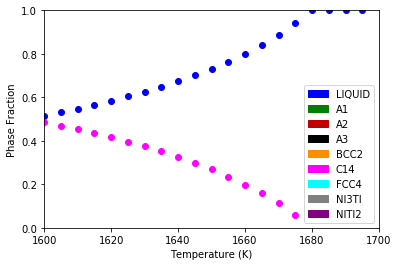

In [60]:
from pycalphad.plot.utils import phase_legend
phase_handles, phasemap = phase_legend(phases)

# plt.gca().set_title('Al-Ni: Phase fractions vs T [X(AL)=0.1]')
ax = plt.gca()
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Phase Fraction')
ax.set_ylim(0, 1.0)
ax.set_xlim(1600, 1700)

for name in phases:
    masked = eq_res.where(eq_res.Phase == name, drop=True)
    plt.scatter(masked.T, masked.NP, color=phasemap[name])
plt.gca().legend(phase_handles, phases, loc='lower right')


In [86]:
eq_res = equilibrium(dbf, comps, phases, {v.P: 101325.0, v.N: 1.0, v.T: (1500, 1620, 5), v.X('NI'): 0.050264, v.X('TI'):0.85641 }, calc_opts={'points': pts_dict})

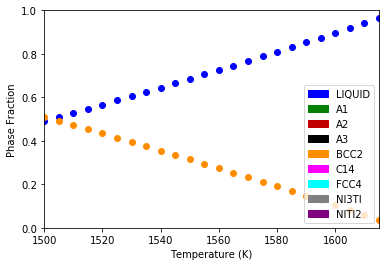

In [88]:
ax = plt.gca()
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Phase Fraction')
ax.set_ylim(0, 1.0)
ax.set_xlim(eq_res.T.min(), eq_res.T.max())

for name in phases:
    masked = eq_res.where(eq_res.Phase == name, drop=True)
    plt.scatter(masked.T, masked.NP, color=phasemap[name])
plt.gca().legend(phase_handles, phases, loc='lower right')



## Test Scheil simulation for binary Fe-Ti system

In [3]:
# Ficticious to show A2/B2 distinction 
res = simulate_scheil_solidification(dbf, ['FE', 'TI', 'VA'], phases, {v.X('TI'): 0.48}, start_temperature=1640, step_temperature=10, verbose=True)
for ph, amnts in res.phase_amounts.items():
    print(f'{ph}: {amnts[-1]:0.4f}')

building callables... done
T=1720.000, X_TI=0.35, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000
T=1710.000, X_TI=0.35, ΔT=10.000, NL: 1.000, NP(LIQUID)=1.000
New phases seen: {'C14'}. Resetting step size
T=1700.000, X_TI=0.35, ΔT=10.000, NL: 0.345, NP(LIQUID)=0.345 NP(C14)=0.655
T=1690.000, X_TI=0.37, ΔT=10.000, NL: 0.205, NP(LIQUID)=0.595 NP(C14)=0.405
T=1680.000, X_TI=0.40, ΔT=10.000, NL: 0.156, NP(LIQUID)=0.760 NP(C14)=0.240
T=1670.000, X_TI=0.41, ΔT=10.000, NL: 0.129, NP(LIQUID)=0.829 NP(C14)=0.171
T=1660.000, X_TI=0.43, ΔT=10.000, NL: 0.112, NP(LIQUID)=0.867 NP(C14)=0.133
T=1650.000, X_TI=0.44, ΔT=10.000, NL: 0.100, NP(LIQUID)=0.892 NP(C14)=0.108
T=1640.000, X_TI=0.45, ΔT=10.000, NL: 0.091, NP(LIQUID)=0.909 NP(C14)=0.091
T=1630.000, X_TI=0.46, ΔT=10.000, NL: 0.084, NP(LIQUID)=0.921 NP(C14)=0.079
T=1620.000, X_TI=0.47, ΔT=10.000, NL: 0.078, NP(LIQUID)=0.931 NP(C14)=0.069
T=1610.000, X_TI=0.47, ΔT=10.000, NL: 0.073, NP(LIQUID)=0.938 NP(C14)=0.062
T=1600.000, X_TI=0.48, ΔT=10.000, NL: 0.069

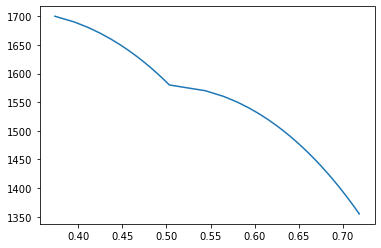

In [6]:
num_plt = np.sum(np.array(binres.fraction_solid) > 0)
x = [z[v.X('TI')] for z in binres.x_liquid][-num_plt:]
T = binres.temperatures[-num_plt:]
plt.plot(x, T)